<a href="https://colab.research.google.com/github/JasonSCFu/Deep-Learning-Basics/blob/main/Object_Detection_using_MMDetection_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection

In this tutorial, I will try:
- the basic structure of Faster R-CNN.
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.


#### source: https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb

## Install MMDetection

In [37]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Sun Aug 28 03:01:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+==========

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:46tcmalloc: large alloc 1147494400 bytes == 0x3a1d2000 @  0x7f783f163615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.2 MB/s eta 0:13:24tcmalloc: large alloc 1434370048 bytes == 0x7e828000 @  0x7f783f163615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [ ]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.7.13 (default, Apr 24 2022, 01:04:09) [GCC 7.5.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 11.1, V11.1.105',
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arc

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.25.1
11.1
GCC 7.3


## Perform Inference with An MMDet detector

### A two-stage detector

In this tutorial, we use Faster R-CNN, a simple two-stage detector as an example.

The high-level architecture of Faster R-CNN is shown in the following picture. More details can be found in the [paper](https://arxiv.org/abs/1506.01497).

![faster rcnn](https://pic1.zhimg.com/80/v2-c0172be282021a1029f7b72b51079ffe_1440w.jpg)

![mmdet](https://pic2.zhimg.com/v2-e49ebcf931b5cf424ed311338f9ff35d_b.jpg)

Briefly, it uses a convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a region proposal network (RPN) to predict proposals, i.e., potential objects. After that, it uses a feature extractor to crop features for the region of interests (RoI), and uses a RoI Head to perform classification and bounding box prediction.


In [ ]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

--2022-08-28 01:26:35--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.71
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

checkpoints/faster_ 100%[===================>] 159.54M  8.87MB/s    in 19s     

2022-08-28 01:26:55 (8.51 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [ ]:
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector


In [ ]:
# Choose to use a config and initialize the detector
config = 'configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'


In [ ]:
# Set the device to be used for evaluation
device='cuda:0'

In [ ]:
# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [ ]:
# Use the detector to do inference
img = '/content/mmdetection/demo/demo.jpg'
result = inference_detector(model, img)

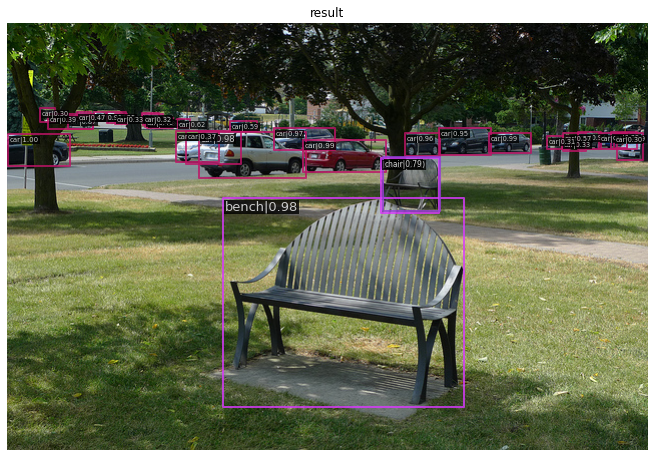

In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train A Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector


### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. Reorganize the dataset into a COCO format.
  2. Reorganize the dataset into a middle format.
  3. Implement a new dataset.


In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html#).

First, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.

In [ ]:
# download, decompress the data
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-08-28 01:47:11--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.89.140.71
Connecting to download.openmmlab.com (download.openmmlab.com)|47.89.140.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  9.49MB/s    in 0.7s    

2022-08-28 01:47:13 (9.49 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [ ]:
# Check the directory structure of the tiny data

# Install tree first
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (106 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg

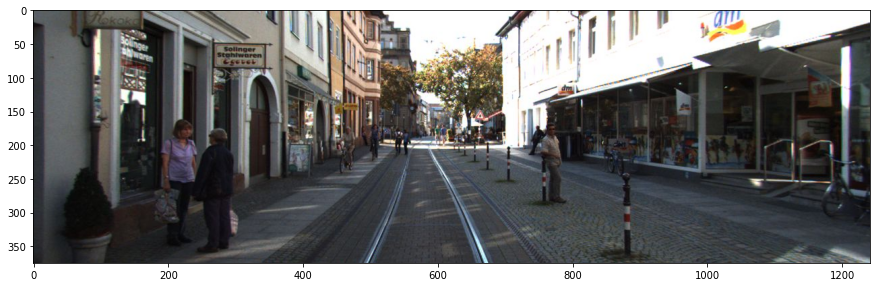

In [ ]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the KITTI annotation format into the middle format. In this tutorial, we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.


In [ ]:
# Check the label of a single image
!cat kitti_tiny/training/label_2/000000.txt

Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01


According to the KITTI's documentation, the first column indicates the class of the object, and the 5th to 8th columns indicate the bboxes. We need to read annotations of each image and convert them into middle format that MMDetection can accept.

In [ ]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/mmdetection/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector! We could make use of the high-level API `train_detector` implemented by MMDetection. This is also used in our training scripts.

In [29]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [33]:
cfg.device='cuda'
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-08-28 02:25:23,447 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by i

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 16.3 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-08-28 02:27:01,826 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 113  | 0.935  | 0.846 |
| Pedestrian | 13  | 47   | 0.846  | 0.762 |
| Cyclist    | 7   | 44   | 0.429  | 0.161 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.590 |
+------------+-----+------+--------+-------+
2022-08-28 02:27:01,829 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5900, mAP: 0.5895



## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


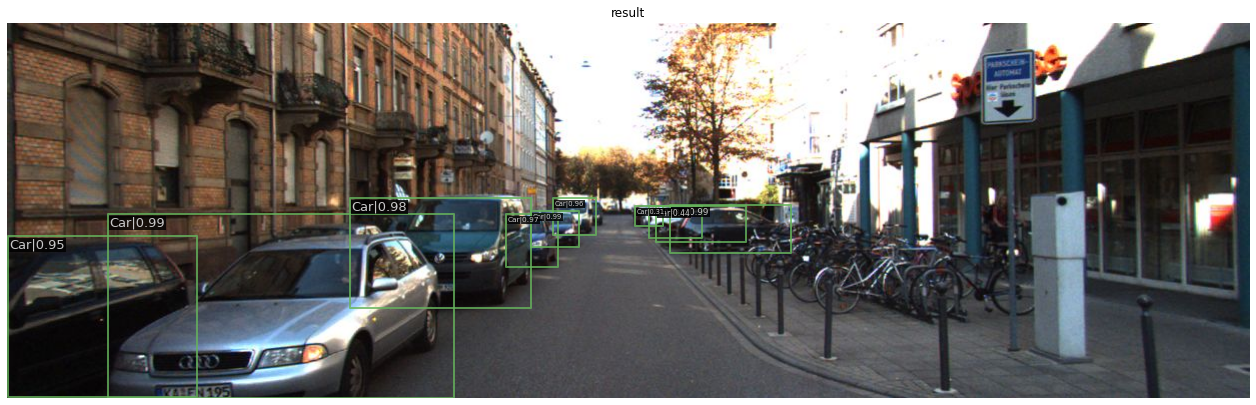

In [36]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)